In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time

In [4]:
(train_images,train_labels),(test_images,test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [5]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
      
    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size
    
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
  
    return model

In [6]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
      
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
       
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
     
    return model

In [7]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [8]:
def generator_loss(generated_output):
    return tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(generated_output), logits = generated_output)


def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want our generated examples to look like it
    real_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(real_output), logits=real_output)

    # [0,0,...,0] with generated images since they are fake
    generated_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(generated_output), logits=generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

In [9]:
generator_optimizer = tf.optimizers.Adam(1e-4)
discriminator_optimizer = tf.optimizers.Adam(1e-4)

In [10]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We'll re-use this random vector used to seed the generator so
# it will be easier to see the improvement over time.
random_vector_for_generation = tf.random.normal([num_examples_to_generate,
                                                 noise_dim])

In [205]:
def train_step(images,old_gen_loss,old_disc_loss):
   # generating noise from a normal distribution
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
      
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images[0], training=True)
        generated_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(generated_output)
        disc_loss = discriminator_loss(real_output, generated_output)


    gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [206]:
def train(dataset, epochs):  
    for epoch in range(epochs):
        start = time.time()
        gen_loss = 500
        disc_loss = 500
        for images in dataset:
            gen_loss,disc_loss = train_step(images,gen_loss,disc_loss)

        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                   epoch + 1,
                                   random_vector_for_generation)

        # saving (checkpoint) the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec'.format(epoch + 1,
                                                      time.time()-start))
    # generating after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           random_vector_for_generation)


In [293]:
train(train_dataset, EPOCHS)

generator 0.751045
discriminator 1.444514
generator 0.7522331
discriminator 1.4140058
generator 0.74551046
discriminator 1.3779311
generator 0.71048725
discriminator 1.4719393
generator 0.70824456
discriminator 1.4232916
generator 0.68237066
discriminator 1.4574437
generator 0.72727126
discriminator 1.4185343
generator 0.7474588
discriminator 1.4228809
generator 0.71331996
discriminator 1.4982717
generator 0.72656816
discriminator 1.4567927
generator 0.7380261
discriminator 1.3682688
generator 0.6931046
discriminator 1.4559752
generator 0.6744834
discriminator 1.4638042
generator 0.6864778
discriminator 1.446059
generator 0.68873775
discriminator 1.4719825
generator 0.71523774
discriminator 1.4512596
generator 0.7172215
discriminator 1.4842293
generator 0.68879247
discriminator 1.4817054
generator 0.7131722
discriminator 1.4312637
generator 0.72329986
discriminator 1.429595
generator 0.73128843
discriminator 1.4236741
generator 0.67851925
discriminator 1.4510993
generator 0.7190745
dis

KeyboardInterrupt: 

In [1]:
plt.imshow(generator(np.random.rand(1,100)).numpy().reshape(28,28))


NameError: name 'plt' is not defined

In [274]:
for train_images_samples, train_labels_samples in train_data:
    print(train_labels)
    break

NameError: name 'train_data' is not defined

# Let's make the discriminator network. It's the same as a normal network except this one just tells us whether an image is fake or not

In [250]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(7,(3,3),padding="same",input_shape=(28,28,1),activation="relu"))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dense(50,activation="relu"))
    model.add(tf.keras.layers.Dense(1))
    return model

In [251]:
model_classifier = make_discriminator_model()

In [83]:
discriminator_model = make_discriminator_model()

In [84]:
def get_discriminator_loss(real_predictions,fake_predictions):
    real_predictions = tf.sigmoid(real_predictions)
    fake_predictions = tf.sigmoid(fake_predictions)
    real_loss = tf.losses.binary_crossentropy(tf.ones_like(real_predictions),real_predictions)
    fake_loss = tf.losses.binary_crossentropy(tf.zeros_like(fake_predictions),fake_predictions)
    return real_loss+ fake_loss
    
    

In [85]:
get_discriminator_loss([1,1,1,1.],[0.,0,0,0])

<tf.Tensor: id=398447, shape=(), dtype=float32, numpy=1.0064085>

In [63]:
discriminator_optimizer = tf.optimizers.Adam(1e-4)

In [267]:
def train():
    for train_images,_ in train_data:
        return train_images
        with tf.GradientTape() as tape:
            train_images = tf.reshape(train_images,(500,28,28,1))
            train_images = (tf.cast(train_images,dtype=tf.dtypes.float32)-127.5)/127.5
            train_images = tf.reshape(train_images,(500,28,28,1))
            fake_images = ((2*np.random.rand(500,28,28,1))-1)
            real_predictions = discriminator_model(train_images)
            fake_predictions = discriminator_model(fake_images)
            loss = get_discriminator_loss(real_predictions,fake_predictions)
            grad = tape.gradient(loss,discriminator_model.variables)
            discriminator_optimizer.apply_gradients(zip(grad,discriminator_model.variables))
            generator_optimizer.apply_gradients()

In [268]:
A = train()

In [271]:
A

<tf.Tensor: id=1271281, shape=(500, 28, 28), dtype=uint8, numpy=
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
    

In [272]:
tf.reshape(A,(-1,28,28,1))

<tf.Tensor: id=1271289, shape=(500, 28, 28, 1), dtype=uint8, numpy=
array([[[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]],


       [[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

  

In [15]:
discriminator_model(np.random.randn(10,28,28,1).astype("float32"))

<tf.Tensor: id=230, shape=(10, 1), dtype=float32, numpy=
array([[-0.68043375],
       [-0.7048673 ],
       [-0.8185603 ],
       [-0.11383929],
       [-0.41929972],
       [-0.28414232],
       [-0.9610402 ],
       [-0.5036322 ],
       [-0.09535562],
       [-0.985209  ]], dtype=float32)>

# Now we will make a generator so that we can make the numbers. 

In [35]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256,input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Reshape((7,7,256)))
    model.add(tf.keras.layers.Conv2DTranspose(128,(3,3),padding="same"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(64,(3,3),strides=(2,2),padding="same"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(1,(3,3),strides=(2,2),padding="same",activation="tanh"))
    
    return model
              
              

In [64]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
      
    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size
    
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)  
    model.add(tf.keras.layers.BatchNormalization(trainable=False))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
  
    return model

In [297]:
def get_generator_loss(fake_predictions):
    fake_predictions = tf.sigmoid(fake_predictions)
    fake_loss = tf.losses.binary_crossentropy(tf.ones_like(fake_predictions),fake_predictions)
    return fake_loss

In [87]:
generator = make_generator_model()

In [119]:
generator_optimizer = tf.optimizers.Adam(1e-3)

In [305]:
def train():
    for train_images_samples,_ in train_data:
        with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
            train_images_samples = tf.reshape(train_images_samples,(500,28,28,1))
            train_images_samples = (tf.cast(train_images_samples,dtype=tf.dtypes.float32)-127.5)/127.5
            fake_images = generator(np.random.rand(500,100))
            real_predictions = discriminator_model(train_images_samples)
            fake_predictions = discriminator_model(fake_images)
            disc_loss = get_discriminator_loss(real_predictions,fake_predictions)
            disc_grad = disc_tape.gradient(disc_loss,discriminator_model.variables)
            gen_loss = get_generator_loss(fake_predictions)
            gen_grad = gen_tape.gradient(gen_loss,generator.variables)
            discriminator_optimizer.apply_gradients(zip(disc_grad,discriminator_model.variables))
            generator_optimizer.apply_gradients(zip(gen_grad,generator.variables))
            print(disc_grad,discriminator_model.variables)
#             print(np.sum(gen_loss.))

In [306]:
generator = make_generator_model()
discriminator_model = make_discriminator_model()
discriminator_optimizer = tf.optimizers.Adam(1e-4)
generator_optimizer = tf.optimizers.Adam(1e-4)
train();

W0330 17:01:40.042024 4738405824 optimizer_v2.py:928] Gradients does not exist for variables ['batch_normalization_v2_51/moving_mean:0', 'batch_normalization_v2_51/moving_variance:0', 'batch_normalization_v2_52/moving_mean:0', 'batch_normalization_v2_52/moving_variance:0', 'batch_normalization_v2_53/moving_mean:0', 'batch_normalization_v2_53/moving_variance:0'] when minimizing the loss.


[<tf.Tensor: id=1297511, shape=(3, 3, 1, 7), dtype=float32, numpy=
array([[[[-42.2797    ,  75.248856  ,   0.5242444 ,  21.720259  ,
          -18.221092  ,  12.662617  ,  -5.238023  ]],

        [[-40.336624  ,  38.55473   ,  -1.8076478 ,  20.861574  ,
          -15.070143  ,  40.483967  ,  -8.335267  ]],

        [[-36.10094   ,  42.173096  ,   2.0886557 ,  -7.611914  ,
           -8.598877  ,  30.783806  , -11.095931  ]]],


       [[[ -2.0658157 ,  61.961243  ,   0.78242856,  29.854778  ,
          -14.348753  ,  11.301836  ,  -0.6633976 ]],

        [[ -4.6981597 ,  29.646677  ,  -3.8763342 ,  30.750751  ,
           -9.492299  ,  29.831837  , -10.700534  ]],

        [[-12.951856  ,  40.01957   ,  -0.20743245,   2.6543212 ,
            0.57461536,  21.46692   ,  -9.410068  ]]],


       [[[ 20.7448    ,   9.35921   ,  -6.386487  ,  35.23032   ,
            0.840677  ,   6.3119454 ,  -0.11352646]],

        [[ 18.481428  , -19.585125  ,  -8.41361   ,  35.937366  ,
            5.33

W0330 17:01:41.513789 4738405824 optimizer_v2.py:928] Gradients does not exist for variables ['batch_normalization_v2_51/moving_mean:0', 'batch_normalization_v2_51/moving_variance:0', 'batch_normalization_v2_52/moving_mean:0', 'batch_normalization_v2_52/moving_variance:0', 'batch_normalization_v2_53/moving_mean:0', 'batch_normalization_v2_53/moving_variance:0'] when minimizing the loss.


[<tf.Tensor: id=1298746, shape=(3, 3, 1, 7), dtype=float32, numpy=
array([[[[ 28.677124  ,  92.41981   ,   1.6189471 ,  17.427876  ,
          -10.61145   ,   3.7845078 ,  -6.064489  ]],

        [[ 29.94526   ,  69.69804   ,  -3.1869977 ,  13.178066  ,
          -11.060592  ,  28.091795  ,  -9.168077  ]],

        [[ 24.380686  ,  75.52791   ,  -0.09488094,  -6.080202  ,
           -5.835282  ,  24.694004  , -14.010462  ]]],


       [[[ 67.881294  ,  86.086494  ,  -0.870136  ,  23.721085  ,
          -15.359618  ,   3.8138459 ,  -4.290189  ]],

        [[ 64.62344   ,  64.99681   ,  -5.464922  ,  19.456245  ,
          -13.796463  ,  24.778337  , -12.546079  ]],

        [[ 51.58476   ,  73.419624  ,  -3.021534  ,  -4.3196483 ,
           -4.724845  ,  20.091139  ,  -9.837582  ]]],


       [[[ 78.864426  ,  48.69242   ,  -4.6885557 ,  27.296192  ,
           -5.329505  ,   7.307824  ,  -0.3058405 ]],

        [[ 76.06731   ,  26.596073  ,  -8.912067  ,  26.187584  ,
           -3.35

KeyboardInterrupt: 

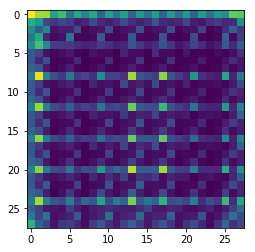

In [20]:
plt.imshow(generator(np.random.rand(1,100)).numpy().reshape(28,28))

In [370]:
discriminator_model.variables

[<tf.Variable 'conv2d_39/kernel:0' shape=(3, 3, 1, 7) dtype=float32, numpy=
 array([[[[-0.0614688 , -0.25358567,  0.06151658,  0.23152536,
           -0.11428817,  0.11089417, -0.28607515]],
 
         [[-0.27830115, -0.08607823, -0.22385886, -0.19035435,
            0.06476752,  0.01051714,  0.27845415]],
 
         [[-0.27063298, -0.01485108,  0.16634855,  0.20455848,
            0.23573458,  0.14153224,  0.2408519 ]]],
 
 
        [[[ 0.22424561, -0.28085235, -0.07391534,  0.14577292,
           -0.21858683,  0.20097701,  0.15587391]],
 
         [[-0.15985166, -0.2634789 , -0.06321431, -0.03677683,
            0.19341245, -0.04805973,  0.07879779]],
 
         [[-0.08044283,  0.2099591 ,  0.2780491 ,  0.06279789,
           -0.032038  , -0.1462281 ,  0.10318536]]],
 
 
        [[[-0.01741749,  0.19221346, -0.05859118, -0.24150465,
            0.238794  ,  0.20164976,  0.08725659]],
 
         [[-0.07059002, -0.2853832 , -0.05064205,  0.01561173,
            0.24226569,  0.03139066,

In [290]:
train_images_samples.shape

TensorShape([500, 28, 28])

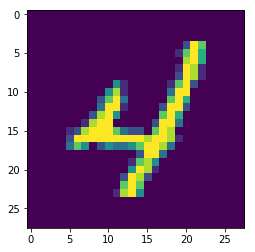

In [207]:
plt.imshow(train_images_samples[0].numpy().reshape((28,28)))

In [208]:
train_images_samples = tf.reshape(train_images_samples,(500,28,28,1))
train_images_samples = (tf.cast(train_images_samples,dtype=tf.dtypes.float32)-127.5)/127.5
discriminator_model(train_images_samples)

<tf.Tensor: id=757770, shape=(500, 1), dtype=float32, numpy=
array([[-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.144735 ],
       [-6.1447